In [1]:
import gym
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = env.unwrapped # 解除对原始gym环境的timelimit封装，不限制每一局的step次数
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(obs_dim, action_dim)

4 2


In [2]:
import torch.nn as nn
import torch.nn.functional as f
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.1)
        # print(self.fc1.weight, self.fc1.weight) # 两者好像没有区别
        self.fc2 = nn.Linear(128, 128)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)
        self.fc3 = nn.Linear(128, action_dim)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.1)
    
    def forward(self, input):
        x = self.fc1(input)
        x1 = f.relu(x)
        x2 = self.fc2(x1)
        x3 = f.relu(x2)
        action_probs = self.fc3(x3)
        return action_probs

In [3]:
import torch

memory_size = 1000
learning_rate = 1e-3
epsilon = 0.1
target_update_interval = 100
batch_size = 128
gamma = 0.95

class DQN():
    def __init__(self):
        super(DQN, self).__init__()
        self.learn_net, self.target_net = Net(), Net()
        self.learning_step = 0
        self.memory_counter = 0
        self.memory = np.zeros((memory_size, 2*obs_dim+2))
        self.optimizer = torch.optim.Adam(self.learn_net.parameters(), lr=learning_rate)
        self.loss_function = nn.MSELoss()
        self.episode_loss = []
        
    def choose_action(self, obs):
        obs = torch.FloatTensor(obs)
        if np.random.rand() >= epsilon:
            action_probs = self.learn_net.forward(obs)
            action = torch.argmax(action_probs).numpy()
        else:
            action = np.random.randint(0, action_dim)
        return action
    
    def store_transition(self, obs, action, reward, next_obs):
        transition = np.hstack((obs, action, reward, next_obs))
        index = self.memory_counter % memory_size
        self.memory[index] = transition
        self.memory_counter += 1
    
    def learn(self, episode, terminated):
        if self.learning_step % target_update_interval == 0:
            self.target_net.load_state_dict(self.learn_net.state_dict())
            
        self.learning_step += 1
        
        sample_index = np.random.choice(memory_size, batch_size)
        batch_data = self.memory[sample_index, :]
        batch_obs = torch.FloatTensor(batch_data[:, :obs_dim])
        # gather(): Expected dtype int64 for index，参考：https://zhuanlan.zhihu.com/p/352877584
        batch_action = torch.LongTensor(batch_data[:, obs_dim:obs_dim+1].astype(int)) 
        batch_reward = torch.FloatTensor(batch_data[:, obs_dim+1:obs_dim+2])
        batch_next_obs = torch.FloatTensor(batch_data[:, -obs_dim:])
        
        state_action_values = self.learn_net(batch_obs).gather(1, batch_action)
        next_state_action_values = self.target_net(batch_next_obs).detach()
        target_state_action_values = batch_reward + gamma*next_state_action_values.max(1)[0].view(batch_size, 1)
        loss = self.loss_function(state_action_values, target_state_action_values)
        
        self.episode_loss.append(loss.data.numpy())
        episode_loss = 0
        if terminated:
            episode_loss = self.episode_loss
            self.episode_loss = []
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return episode_loss
        
    def reward_function(self, next_obs):
        x, x_dot, theta, theta_dot = next_obs
        r1 = (env.x_threshold - abs(x))/env.x_threshold - 0.5
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        reward = r1 + r2
        return reward

In [4]:
def main():
    dqn = DQN()
    for episode in range(200):
        obs, info= env.reset()
        episode_reward = 0
        step = 0
        while True:
            action = dqn.choose_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            step += 1
            reward = dqn.reward_function(next_obs)
            dqn.store_transition(obs, action, reward, next_obs)
            episode_reward += reward
            if dqn.memory_counter >= memory_size:
                episode_loss = dqn.learn(episode, terminated)
                torch.save(dqn.learn_net.state_dict(), "./saved_models/CartPole-v1.pt")
                if (terminated or truncated) and (episode+1) % 10 == 0:
                    print(f"episode:{episode+1},step:{step},episode_reward:{episode_reward},avg_episode_loss:{np.mean(np.array(episode_loss))}")
            if terminated or truncated:
                break
            obs = next_obs

if __name__ == "__main__":
    main()

episode:110,step:9,episode_reward:5.03179860027931,avg_episode_loss:0.017654838040471077
episode:120,step:38,episode_reward:15.590566380617318,avg_episode_loss:0.04371381923556328
episode:130,step:120,episode_reward:61.53139504529783,avg_episode_loss:0.018523667007684708
episode:140,step:854,episode_reward:517.4994922788286,avg_episode_loss:0.001066695898771286
episode:150,step:1070,episode_reward:633.5336612382536,avg_episode_loss:0.0004420429759193212
episode:160,step:3690,episode_reward:2222.230818443684,avg_episode_loss:0.0005094236112199724
episode:170,step:2021,episode_reward:1565.133092119154,avg_episode_loss:0.00031189018045552075
episode:180,step:2099,episode_reward:1157.3538464195808,avg_episode_loss:0.00035325283533893526
episode:190,step:4134,episode_reward:1911.8440232426292,avg_episode_loss:0.00035107129951938987
episode:200,step:1754,episode_reward:1307.0938326813257,avg_episode_loss:0.00023259299632627517


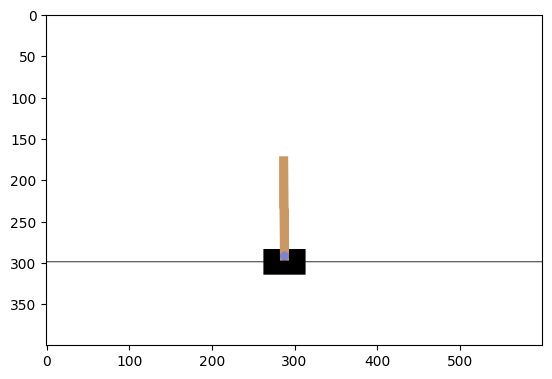

episode:1,step:100,episode_reward:96.49069551428258


In [5]:
import matplotlib.pyplot as plt
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output
eval_net = Net()
eval_net.load_state_dict(torch.load("./saved_models/CartPole-v1.pt"))
eval_net.eval()

def reward_function(next_obs):
        x, x_dot, theta, theta_dot = next_obs
        r1 = (env.x_threshold - abs(x))/env.x_threshold - 0.5
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        reward = r1 + r2
        return reward
    
for episode in range(1):
    obs, info = env.reset()
    episode_reward = 0
    for step in range(100):
        obs = torch.FloatTensor(obs)
        action = torch.argmax(eval_net.forward(obs)).numpy()
        next_obs, reward, terminated, truncated, info = env.step(action)
        reward = reward_function(next_obs)
        episode_reward += reward
        if terminated or truncated:
            break
        obs = next_obs
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()
    print(f"episode:{episode+1},step:{step+1},episode_reward:{episode_reward}")
    
env.close()